In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [4]:
TEST_SIZE = 0.25
RANDOM_STATE = 1533
NO_EPOCHS = 50
BATCH_SIZE = 128

In order to get the data, we would need to collect a large number of fashion related images. Thankfully MNIST-Fashion is a dataset that contains 60000 training images with a separate 10000 images for testing. 


The data can be added to the notebook via the api: tfds.image_classification.FashionMNIST

However, I've decided to manually add the dataset as a csv

The models used have been listed below in decreasing Test Error Rate%:



    Linear Classifiers
    
    K-Nearest Neighbours
    
    Boosted Stumps
    
    Non-Linear Classifiers
    
    SVMs
    
    Neural Networks
    
    Convolutional Neural Networks

In [5]:
train = pd.read_csv('train.csv')

In [6]:
test = pd.read_csv('test.csv')

In [7]:
print("Fashion MNIST test rows:",test.shape[0], "Fashion MNIST test columns:",test.shape[1])

Fashion MNIST test rows: 10000 Fashion MNIST test columns: 785


In [8]:
print("Fashion MNIST train rows:",train.shape[0], "Fashion MNIST train columns:",train.shape[1])

Fashion MNIST train rows: 60000 Fashion MNIST train columns: 785


The labels are given by the fashion items in the data

In [9]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

A function defined and data_contents is created to see the contents of the dataset after being labeled

In [10]:
def data_contents(data):
    for i in range (10):
        label_count = data[data.label==1].shape[0]
        count = len(data)
        print(f'{labels[i]:<15}    : {label_count}')

The contents of the training dataset is shown below:

In [11]:
data_contents(train)

T-shirt/top        : 6000
Trouser            : 6000
Pullover           : 6000
Dress              : 6000
Coat               : 6000
Sandal             : 6000
Shirt              : 6000
Sneaker            : 6000
Bag                : 6000
Ankle Boot         : 6000


A sample of the data is shown below using the function sample_images

In [12]:
def sample_images(data):
    # Empty list that will contain the sample images
    sample_images = []
    sample_labels = []
    # Iterate over the keys of the labels dictionary defined above
    for k in labels.keys():
        # Each category will have three samples
        samples = data[data["label"] == k].head(3)
        # Add samples to sample list
        for j, s in enumerate(samples.values):
            # As the First column contain labels, index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(28,28)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total sample images: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images(train)

Total sample images:  30


In [13]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,6, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//6, i%6].imshow(img, cmap=cmap)
        ax[i//6, i%6].axis('off')
        ax[i//6, i%6].set_title(labels[data_sample_labels[i]])
    plt.show()    

Training sample images are shown below

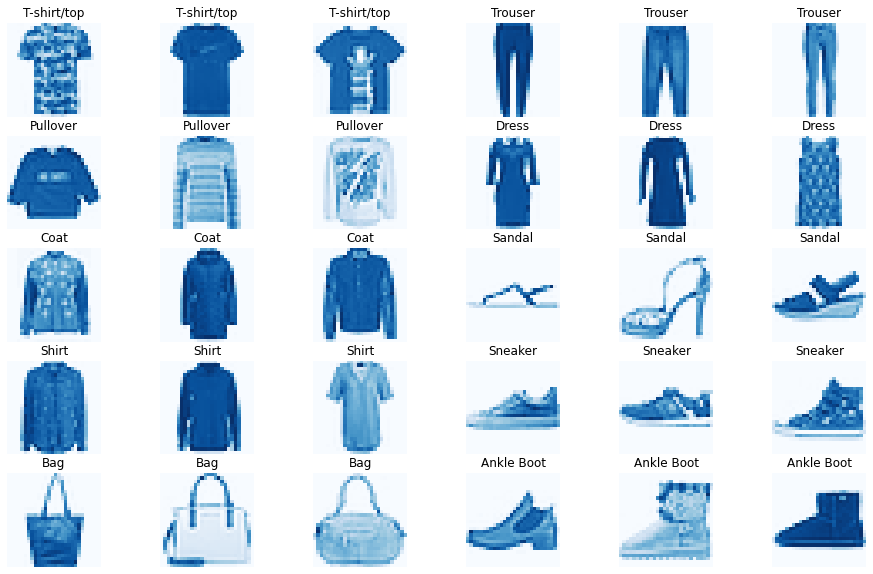

In [14]:
plot_sample_images(train_sample_images,train_sample_labels)

Test sample images are shown below

Total sample images:  30


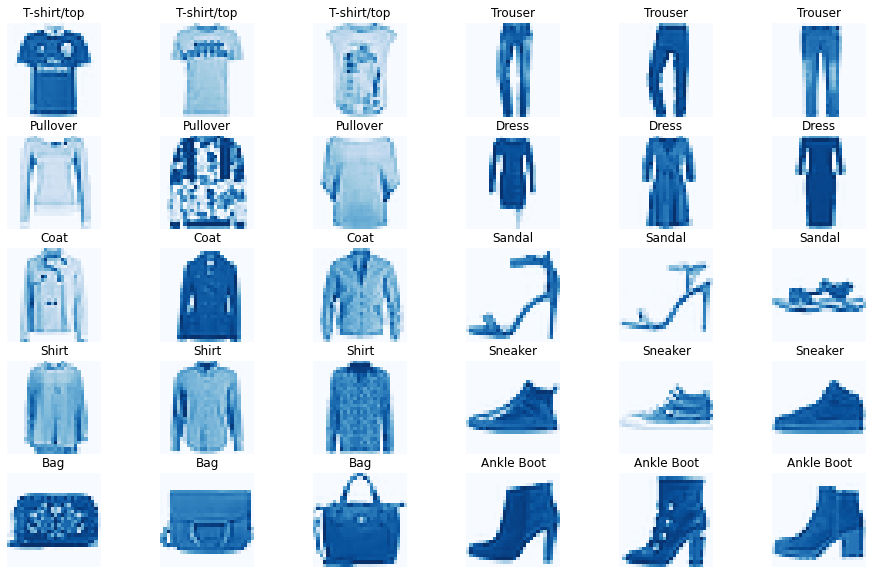

In [15]:
test_sample_images, test_sample_labels = sample_images(test)
plot_sample_images(test_sample_images,test_sample_labels)

Data Preprocessing function, here we reshape the columns to 28, 28, 1 from 784 and save the target as a separate vector

In [16]:
def data_preprocessing(raw):
    x_as_array = raw.values[:,1:]
    num_images = raw.shape[0]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    x_out = x_shaped_array / 255    
    y_out = keras.utils.to_categorical(raw.label, 10)
    
    return x_out, y_out

The training and testing data goes through the data preprocessing

In [17]:
X, y = data_preprocessing(train)
X_test, y_test = data_preprocessing(test)

The training data is split into training and validation

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [19]:
print("Fashion MNIST train rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train rows: 45000  columns: (28, 28, 1)
Fashion MNIST valid rows: 15000  columns: (28, 28, 1)
Fashion MNIST test rows: 10000  columns: (28, 28, 1)


In [20]:
def get_count_per_class(cc):
    ccf = pd.DataFrame(cc)
    # Get the count for each label
    label_counts = ccf[0].value_counts()

    # Get total number of samples
    total_samples = len(cc)

    # Items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        print("{:<20s}:   {}".format(label, count))
    


In [21]:
#Training Set contents, Y
get_count_per_class(np.argmax(y_train,axis=1))

T-shirt/top         :   4548
Shirt               :   4523
Pullover            :   4515
Dress               :   4502
Coat                :   4498
Ankle Boot          :   4496
Sneaker             :   4491
Sandal              :   4490
Trouser             :   4472
Bag                 :   4465


In [22]:
#Validation Set contents, Y
get_count_per_class(np.argmax(y_val,axis=1))

Bag                 :   1535
Trouser             :   1528
Sandal              :   1510
Sneaker             :   1509
Ankle Boot          :   1504
Coat                :   1502
Dress               :   1498
Pullover            :   1485
Shirt               :   1477
T-shirt/top         :   1452


The model will be a sequential model, this is a linear stack of layers


There will be a 2D convolutional layer with:

32 filters with 3 x 3 dimension, Relu actication function.

Max Pooling operation has:

A pool size of 2,2 which is the downsizing factor in each direction.

2D Layer with 128 filters and 3 x 3 dimension and Relu activation function

Flatten input layer which flattens the input

Dense layer with a dimensionality of 128

Final Dense layer has 10 classes (unique items in the data), softmax activation

In [23]:

model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

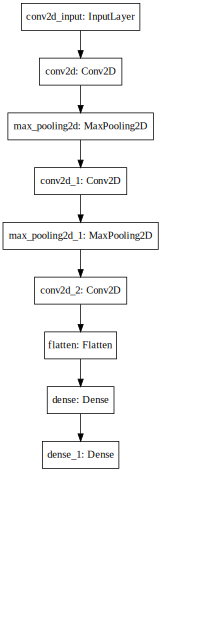

In [25]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
352/352 [==============================] - 30s 86ms/step - loss: 0.5444 - accuracy: 0.7993 - val_loss: 0.4126 - val_accuracy: 0.8491
Epoch 2/50
352/352 [==============================] - 28s 80ms/step - loss: 0.3456 - accuracy: 0.8744 - val_loss: 0.3329 - val_accuracy: 0.8809
Epoch 3/50
352/352 [==============================] - 30s 85ms/step - loss: 0.2901 - accuracy: 0.8949 - val_loss: 0.2924 - val_accuracy: 0.8926
Epoch 4/50
352/352 [==============================] - 29s 83ms/step - loss: 0.2555 - accuracy: 0.9073 - val_loss: 0.2800 - val_accuracy: 0.9003
Epoch 5/50
352/352 [==============================] - 30s 84ms/step - loss: 0.2265 - accuracy: 0.9179 - val_loss: 0.2657 - val_accuracy: 0.9045
Epoch 6/50
352/352 [==============================] - 29s 83ms/step - loss: 0.2017 - accuracy: 0.9265 - val_loss: 0.2498 - val_accuracy: 0.9095
Epoch 7/50
352/352 [==============================] - 30s 84ms/step - loss: 0.1812 - accuracy: 0.9328 - val_loss: 0.2602 - val_accuracy:

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7485931515693665
Test accuracy: 0.9115999937057495


In [28]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

In [29]:
#predicted = model.predict_classes(X_test)
predicted = np.argmax(model.predict(X_test), axis=-1)
y_true = test.iloc[:, 0]

In [30]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 


In [31]:
def display_images(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    rows = 3
    cols = 5
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(15,10))
    for row in range(rows):
        for col in range(cols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted :{}\nTrue :{}".format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1


Below are images that were correctly predicted by the model

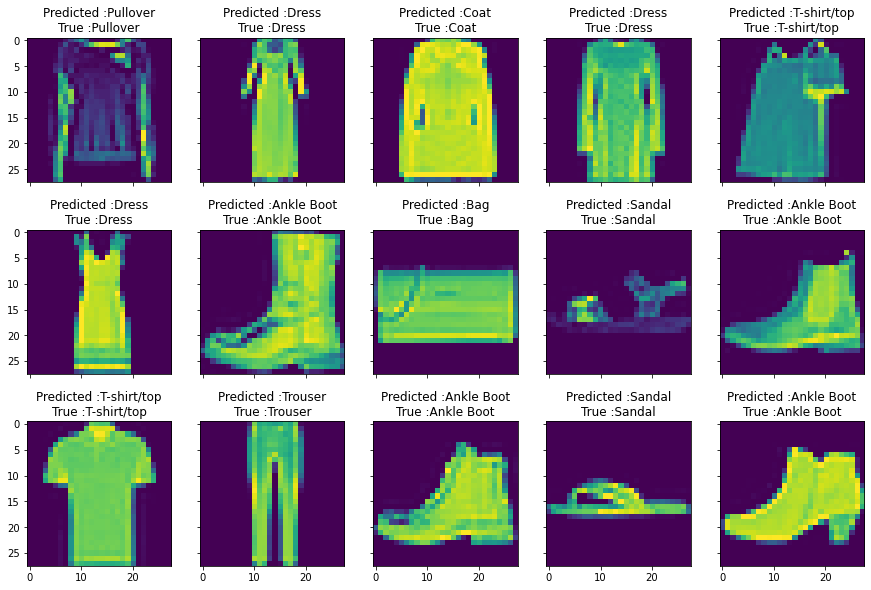

In [32]:
# Correct images is when the true and predicted are the same
correct = (Y_pred_classes - Y_true == 0)

Y_pred_classes_correct = Y_pred_classes[correct]
Y_pred_correct = Y_pred[correct]
Y_true_correct = Y_true[correct]
X_val_correct = X_val[correct]

# Probabilities of correct
Y_pred_correct_prob = np.max(Y_pred_correct,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_correct = np.diagonal(np.take(Y_pred_correct, Y_true_correct, axis=1))

# Probability difference of the predicted label and the true label
delta_pred_true_correct = Y_pred_correct_prob - true_prob_correct

# List of the delta prob errors
sorted_dela_correct = np.argsort(delta_pred_true_correct)

# Top 6 Correct and Displayed
most_important_correct = sorted_dela_correct[-15:]
display_images(most_important_correct, X_val_correct, Y_pred_classes_correct, Y_true_correct)

Below are clothes incorrectly predicted by the model

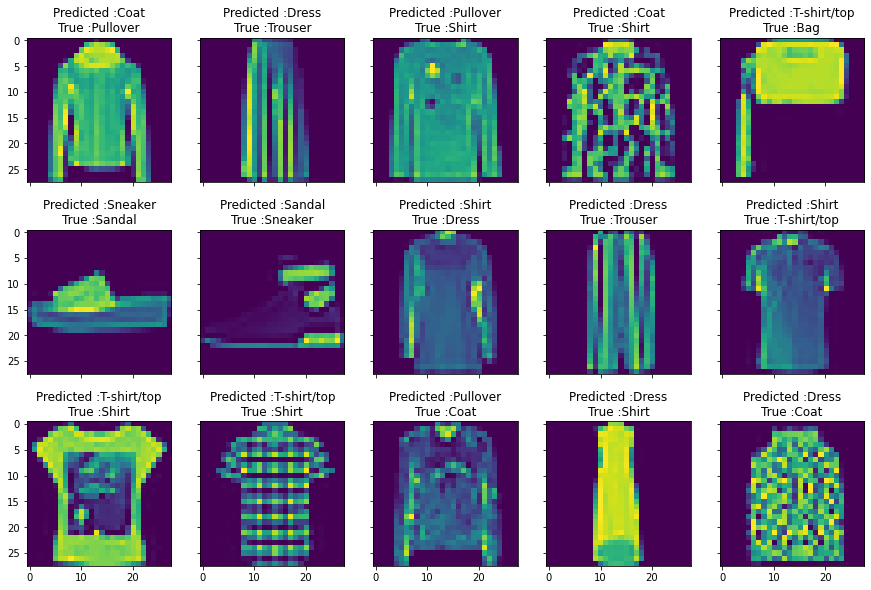

In [33]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

# Probabilities of incorrect
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Probability difference of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# List of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors and Displayed 
most_important_errors = sorted_dela_errors[-15:]
display_images(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The precision for each class is shown below

In [34]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(10)]
print(classification_report(y_true, predicted, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.83      0.89      0.86      1000
    Class 1 (Trouser) :       0.99      0.98      0.99      1000
   Class 2 (Pullover) :       0.89      0.86      0.87      1000
      Class 3 (Dress) :       0.89      0.95      0.92      1000
       Class 4 (Coat) :       0.89      0.86      0.87      1000
     Class 5 (Sandal) :       0.98      0.97      0.97      1000
      Class 6 (Shirt) :       0.77      0.72      0.75      1000
    Class 7 (Sneaker) :       0.93      0.96      0.95      1000
        Class 8 (Bag) :       0.98      0.97      0.98      1000
 Class 9 (Ankle Boot) :       0.97      0.95      0.96      1000

               accuracy                           0.91     10000
              macro avg       0.91      0.91      0.91     10000
           weighted avg       0.91      0.91      0.91     10000

